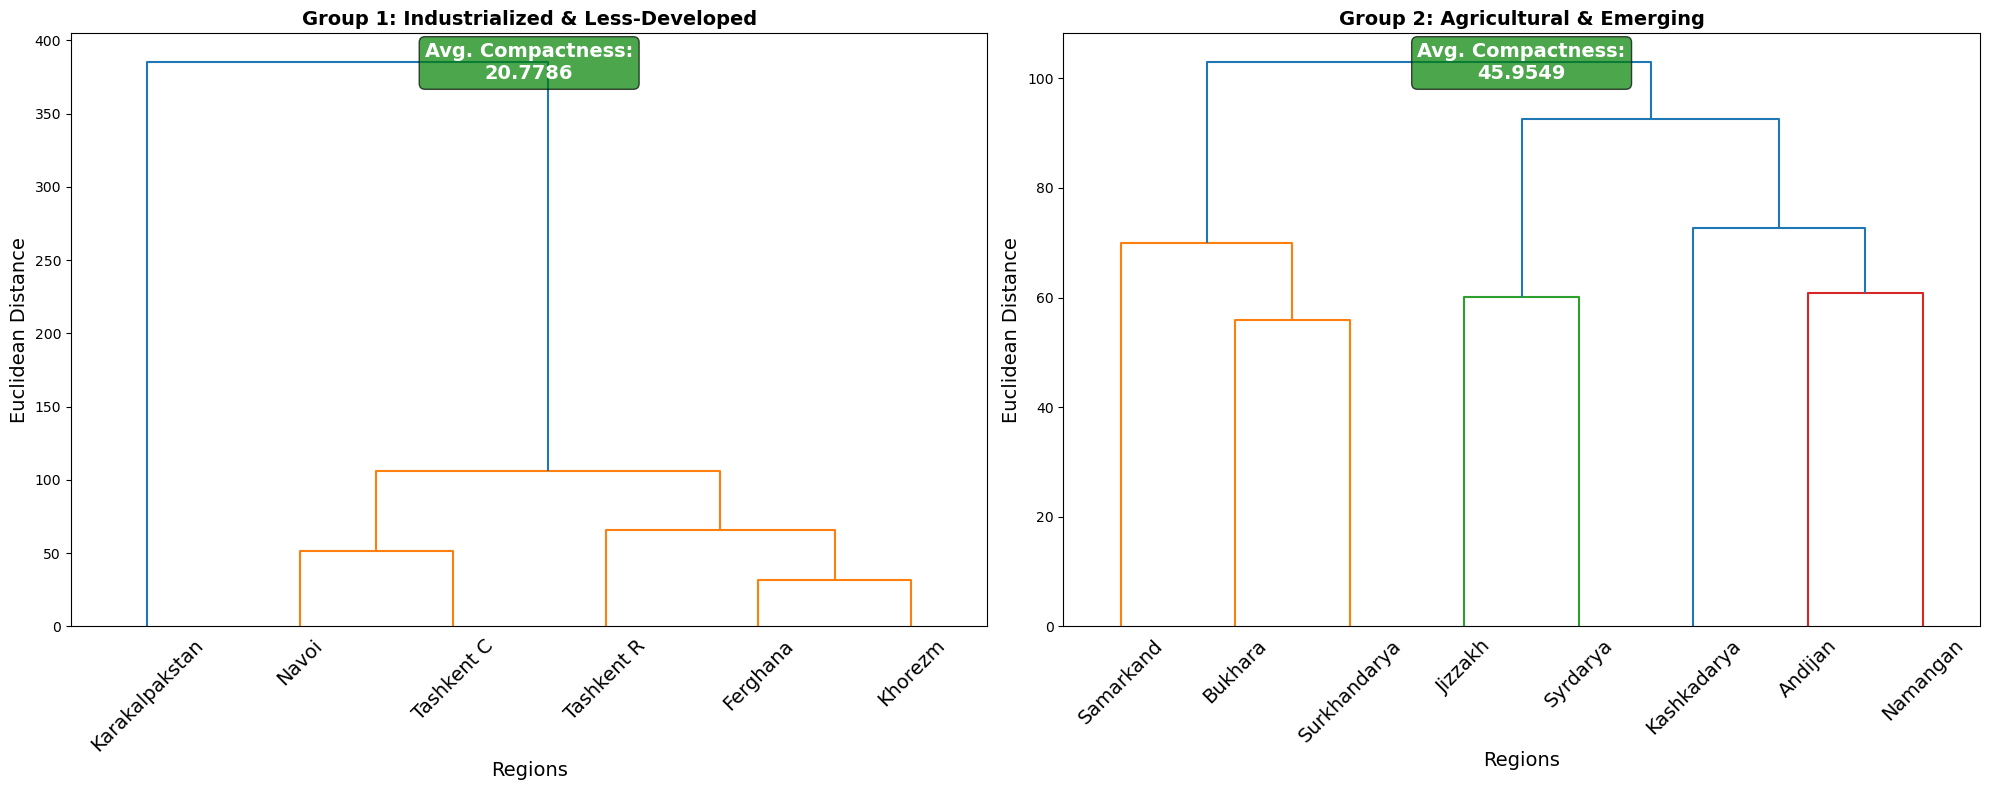

Compactness for Group 1: {1: 51.533481519202184, 2: 31.580962345376047, 3: 0, 4: 0}
Average Compactness for Group 1: 20.77861096614456

Compactness for Group 2: {1: 62.82604621666824, 2: 60.14348140958154, 3: 60.85000735125285, 4: 0}
Average Compactness for Group 2: 45.95488374437566


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Load datasets into a dictionary
file_names = [
    "Tuberc", "Brucellosis", "Dysentery", "Measles", 
    "Meningococcal_inf", "Scarlet_fever", "Typhoid_fever"
]

file_paths = [
    "Tuberc.csv",
    "Brucellosis.csv",
    "Dysentery.csv",
    "Measles.csv",
    "Meningococcal_inf.csv",
    "Scarlet_fever.csv",
    "Typhoid_fever.csv",
]

datasets = {name: pd.read_csv(path) for name, path in zip(file_names, file_paths)}

# Perform a series of merges on the 'Territories' column
merged_data = datasets[file_names[0]]
for name in file_names[1:]:
    merged_data = pd.merge(
        merged_data, datasets[name], on="Territories", how="outer", suffixes=("", f"_{name}")
    )

# Split data into two groups based on EZone
group1_zones = ["Industrialized", "Less Developed"]
group2_zones = ["Agricultural", "Emerging"]

group1_data = merged_data[merged_data["EZone"].isin(group1_zones)]
group2_data = merged_data[merged_data["EZone"].isin(group2_zones)]

# Function to calculate compactness
def calculate_cluster_compactness(data, linkage_matrix, num_clusters):
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    distances = pdist(data, metric='euclidean')
    distance_matrix = squareform(distances)
    compactness = {}
    for cluster_id in range(1, num_clusters + 1):
        indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        if len(indices) > 1:
            within_cluster_distances = distance_matrix[indices][:, indices]
            avg_distance = within_cluster_distances[np.triu_indices_from(within_cluster_distances, k=1)].mean()
        else:
            avg_distance = 0
        compactness[cluster_id] = avg_distance
    avg_compactness = np.mean(list(compactness.values()))
    return compactness, avg_compactness

# Function to create a dendrogram and calculate compactness
def create_dendrogram_with_compactness(ax, data, title, num_clusters):
    numerical_data = data.iloc[:, 3:].apply(pd.to_numeric, errors='coerce').dropna(axis=1)
    numerical_data = numerical_data.fillna(numerical_data.mean())
    distances = pdist(numerical_data, metric='euclidean')
    linkage_matrix = linkage(distances, method='ward')
    dendro = dendrogram(
        linkage_matrix,
        labels=data['Territories'].values,
        leaf_rotation=45,  # Rotate labels 45 degrees
        leaf_font_size=14,  # Increase font size
        ax=ax
    )
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Regions", fontsize=14)
    ax.set_ylabel("Euclidean Distance", fontsize=14)
    compactness, avg_compactness = calculate_cluster_compactness(numerical_data, linkage_matrix, num_clusters)
    ax.text(0.5, 0.95, f"Avg. Compactness:\n{avg_compactness:.4f}", 
            transform=ax.transAxes, fontsize=14, color='white', 
            weight='bold', ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="green", alpha=0.7))
    return compactness, avg_compactness

# Create subplots for side-by-side dendrograms
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=100)
compactness_group1, avg_compactness_group1 = create_dendrogram_with_compactness(
    axes[0], group1_data, "Group 1: Industrialized & Less-Developed", num_clusters=4
)
compactness_group2, avg_compactness_group2 = create_dendrogram_with_compactness(
    axes[1], group2_data, "Group 2: Agricultural & Emerging", num_clusters=4
)

# Adjust layout and display
plt.tight_layout()
plt.grid(visible=False)
plt.show()

# Print compactness results
print("Compactness for Group 1:", compactness_group1)
print("Average Compactness for Group 1:", avg_compactness_group1)
print("\nCompactness for Group 2:", compactness_group2)
print("Average Compactness for Group 2:", avg_compactness_group2)

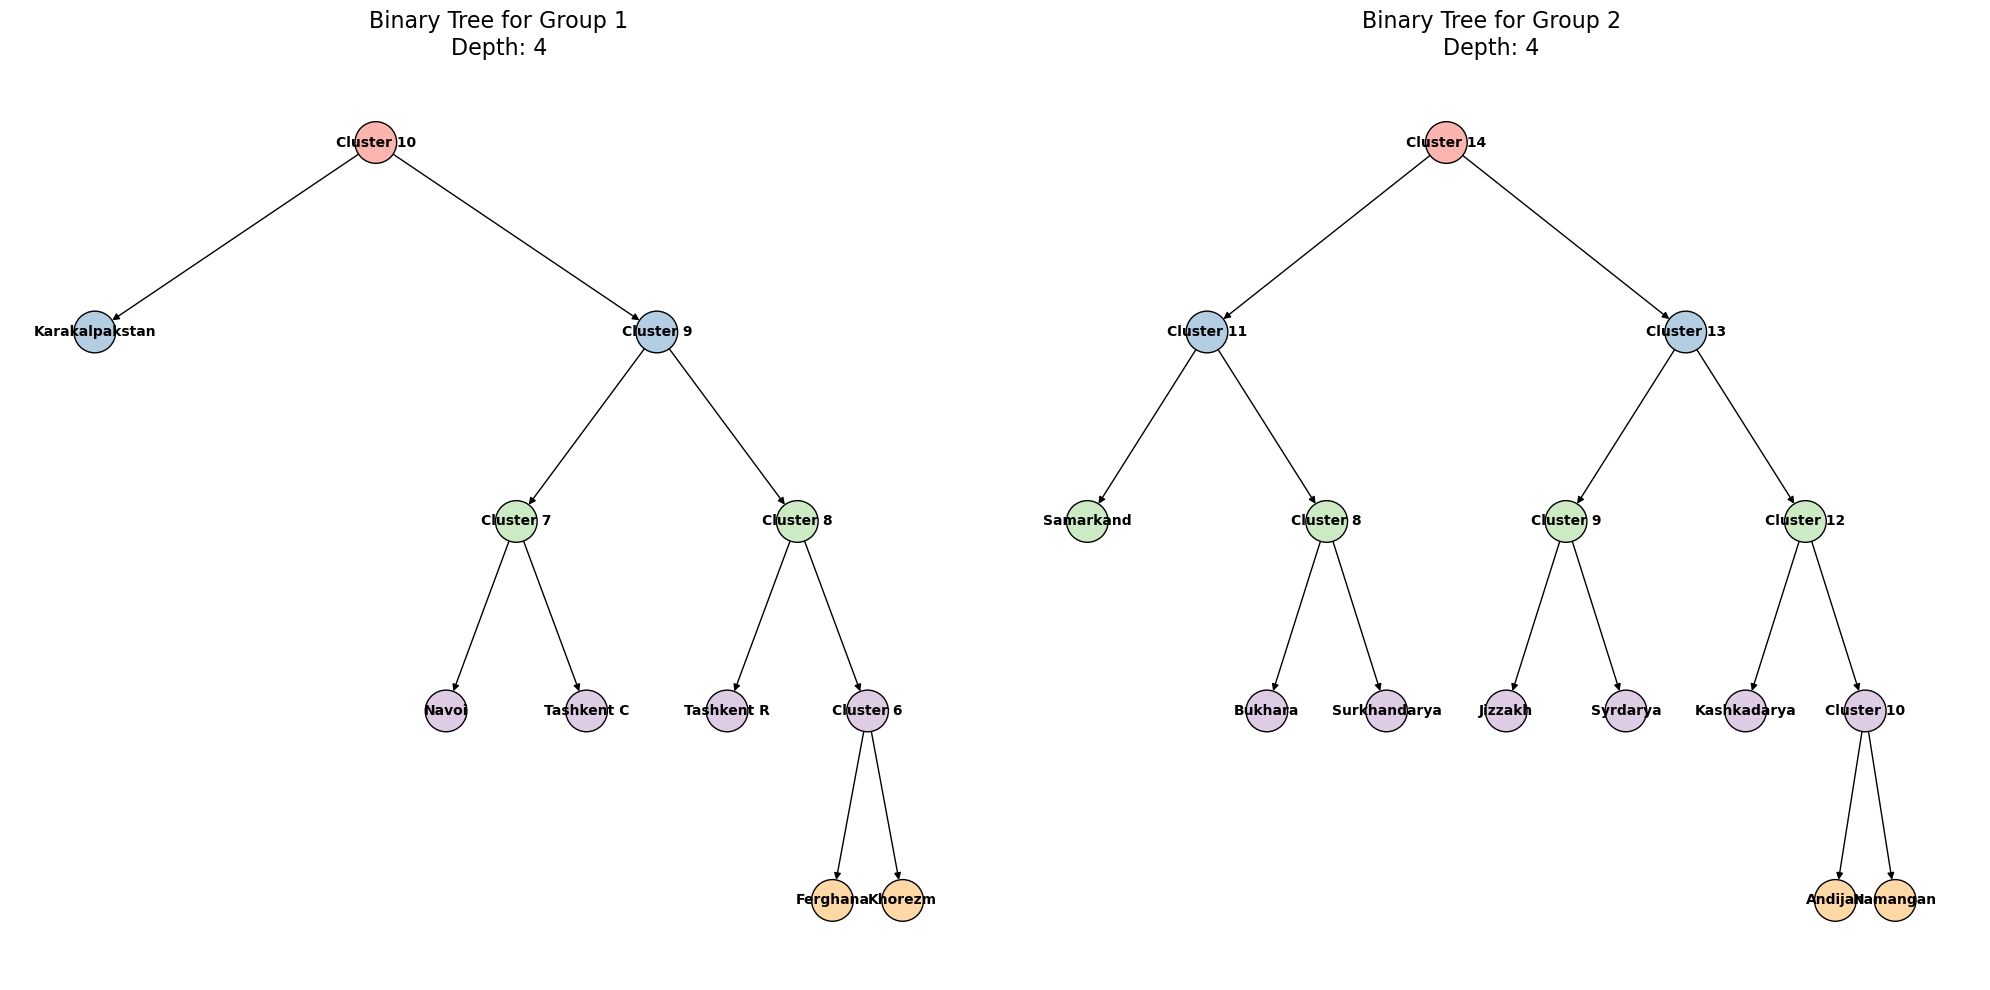

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd


# Define the TreeNode class
class TreeNode:
    def __init__(self, name, left=None, right=None):
        self.name = name
        self.left = left
        self.right = right


# Function to build a binary tree from a linkage matrix
def build_binary_tree(linkage_matrix, labels):
    nodes = [TreeNode(name=label) for label in labels]  # Leaf nodes
    for i, (left, right, _, _) in enumerate(linkage_matrix):
        parent_name = f"Cluster {len(labels) + i}"  # Internal cluster nodes
        left_node = nodes[int(left)]
        right_node = nodes[int(right)]
        parent_node = TreeNode(name=parent_name, left=left_node, right=right_node)
        nodes.append(parent_node)
    return nodes[-1]  # Root node


# Function to visualize a binary tree
def visualize_binary_tree(tree, title, ax):
    def add_edges_and_labels(graph, root, pos, labels, depths, depth=0, x=0, y=0, width=2.0, height=1.5):
        graph.add_node(root.name)
        pos[root.name] = (x, y)
        labels[root.name] = root.name
        depths[root.name] = depth

        if root.left:
            graph.add_edge(root.name, root.left.name)
            add_edges_and_labels(graph, root.left, pos, labels, depths, depth + 1, x - width, y - height, width * 0.5, height)
        if root.right:
            graph.add_edge(root.name, root.right.name)
            add_edges_and_labels(graph, root.right, pos, labels, depths, depth + 1, x + width, y - height, width * 0.5, height)

    G, pos, labels, depths = nx.DiGraph(), {}, {}, {}
    add_edges_and_labels(G, tree, pos, labels, depths)
    max_depth = max(depths.values())
    node_colors = [plt.cm.Pastel1(depths[n] % plt.cm.Pastel1.N) for n in G.nodes]

    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        labels=labels,
        node_size=900,
        node_color=node_colors,
        font_size=10,
        font_weight="bold",
        edgecolors="black"
    )
    ax.set_title(f"{title}\nDepth: {max_depth}", fontsize=16)


# Prepare data for clustering
numerical_data1 = group1_data.iloc[:, 3:].apply(pd.to_numeric, errors='coerce').dropna(axis=1).fillna(0)
numerical_data2 = group2_data.iloc[:, 3:].apply(pd.to_numeric, errors='coerce').dropna(axis=1).fillna(0)

# Generate linkage matrices
linkage_data1 = linkage(pdist(numerical_data1), method='ward')
linkage_data2 = linkage(pdist(numerical_data2), method='ward')

# Build binary trees from the linkage matrices
binary_tree1 = build_binary_tree(linkage_data1, labels=group1_data['Territories'].values)
binary_tree2 = build_binary_tree(linkage_data2, labels=group2_data['Territories'].values)

# Visualize binary trees
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
visualize_binary_tree(binary_tree1, "Binary Tree for Group 1", ax1)
visualize_binary_tree(binary_tree2, "Binary Tree for Group 2", ax2)

plt.tight_layout()
plt.show()

Yearly Compactness for Group 1 (Filled Missing Values):
    Year  Compactness
0   1991     0.000000
1   1992     6.186321
2   1993     6.649393
3   1994     5.470847
4   1995     5.319053
5   1996     6.273856
6   1997     5.395529
7   1998     6.478280
8   1999     7.910439
9   2000    10.085226
10  2001     6.635246
11  2002     8.220952
12  2003     5.624079
13  2004     6.173017
14  2005     6.173017
15  2006     6.173017
16  2007     6.173017
17  2008     6.173017
18  2009     6.173017
19  2010     6.173017
20  2011     6.173017
21  2012     6.173017
22  2013     6.173017
23  2014     6.173017
24  2015     6.173017
25  2016     6.173017
26  2017     6.173017
27  2018     6.173017
28  2019     6.173017
29  2020     6.173017

Yearly Compactness for Group 2 (Filled Missing Values):
    Year  Compactness
0   1991     0.000000
1   1992     2.827435
2   1993     2.407115
3   1994     2.280399
4   1995     2.361434
5   1996     3.137888
6   1997     2.550425
7   1998     2.717012
8   199

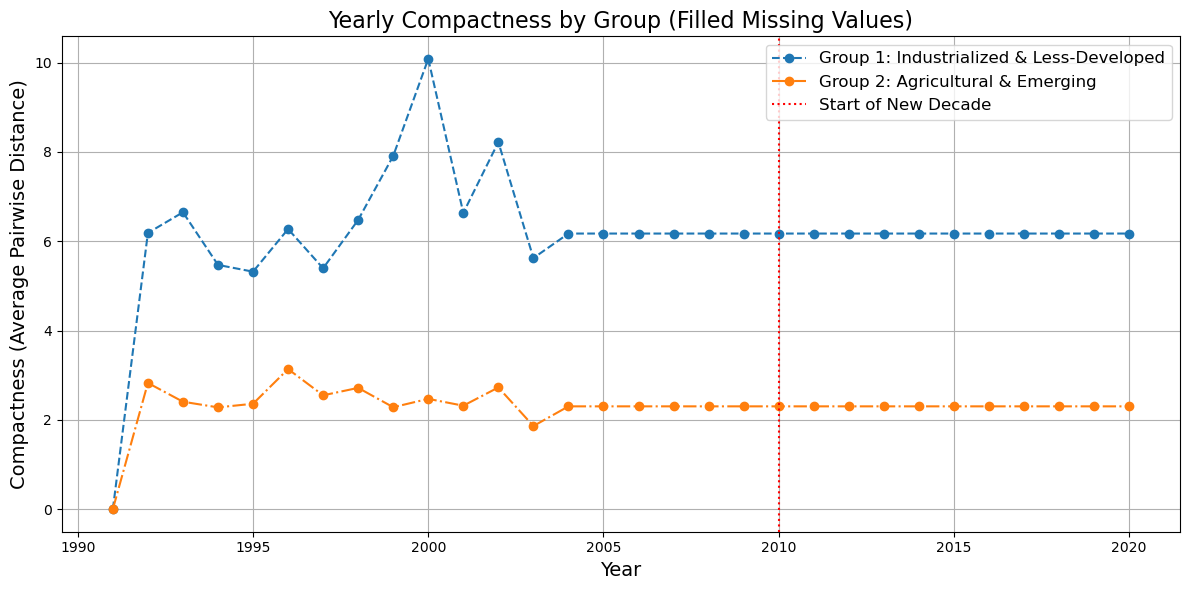

In [19]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Load datasets into a dictionary
uploaded_files = {
    "Tuberc": pd.read_csv("Tuberc.csv"),
    "Brucellosis": pd.read_csv("Brucellosis.csv"),
    "Dysentery": pd.read_csv("Dysentery.csv"),
    "Measles": pd.read_csv("Measles.csv"),
    "Meningococcal_inf": pd.read_csv("Meningococcal_inf.csv"),
    "Scarlet_fever": pd.read_csv("Scarlet_fever.csv"),
    "Typhoid_fever": pd.read_csv("Typhoid_fever.csv"),
}

# Define Group 1 and Group 2 regions
group_1_regions = [
    "Navoi", "Tashkent C", "Tashkent R", "Fergana", "Khorezm", "Karakalpakstan"
]
group_2_regions = [
    "Andijan", "Namangan", "Kashkadarya", "Jizzakh", "Syrdarya", "Samarkand", "Bukhara", "Surkhandarya"
]

# Function to calculate yearly compactness for a single dataset and a group of regions
def calculate_yearly_compactness(data, regions):
    filtered_data = data[data["Territories"].isin(regions)]
    melted_data = filtered_data.melt(id_vars=["№", "Territories", "EZone"], var_name="Year", value_name="Value")
    melted_data["Year"] = pd.to_numeric(melted_data["Year"], errors="coerce")
    melted_data["Value"] = pd.to_numeric(melted_data["Value"], errors="coerce")
    melted_data = melted_data.dropna(subset=["Year", "Value"])

    compactness_scores = []
    for year, group in melted_data.groupby("Year"):
        values = group["Value"].values.reshape(-1, 1)
        if len(values) > 1:
            distances = pdist(values, metric="euclidean")
            compactness = np.mean(distances)
        else:
            compactness = 0  # Setting compactness to 0 if there's not enough data
        compactness_scores.append({"Year": year, "Compactness": compactness})
    
    return pd.DataFrame(compactness_scores)

# Aggregate yearly compactness across all datasets
def aggregate_compactness(datasets, regions):
    combined_compactness = None
    for name, data in datasets.items():
        yearly_compactness = calculate_yearly_compactness(data, regions)
        if combined_compactness is None:
            combined_compactness = yearly_compactness
        else:
            combined_compactness["Compactness"] += yearly_compactness["Compactness"]
    
    combined_compactness["Compactness"] /= len(datasets)
    return combined_compactness

# Calculate compactness for Group 1 and Group 2
group1_data_compactness = aggregate_compactness(uploaded_files, group_1_regions)
group2_data_compactness = aggregate_compactness(uploaded_files, group_2_regions)

# Set the first year's compactness to 0
group1_data_compactness.loc[group1_data_compactness["Year"] == group1_data_compactness["Year"].min(), "Compactness"] = 0
group2_data_compactness.loc[group2_data_compactness["Year"] == group2_data_compactness["Year"].min(), "Compactness"] = 0

# Fill NaN values with the mean compactness for each group
group1_data_compactness["Compactness"].fillna(group1_data_compactness["Compactness"].mean(), inplace=True)
group2_data_compactness["Compactness"].fillna(group2_data_compactness["Compactness"].mean(), inplace=True)

# Print the updated compactness values
print("Yearly Compactness for Group 1 (Filled Missing Values):")
print(group1_data_compactness)
print("\nYearly Compactness for Group 2 (Filled Missing Values):")
print(group2_data_compactness)

# Plot the compactness values
plt.figure(figsize=(12, 6))
plt.plot(
    group1_data_compactness["Year"],
    group1_data_compactness["Compactness"],
    marker="o", label="Group 1: Industrialized & Less-Developed", linestyle="--"
)
plt.plot(
    group2_data_compactness["Year"],
    group2_data_compactness["Compactness"],
    marker="o", label="Group 2: Agricultural & Emerging", linestyle="-."
)
plt.axvline(x=2010, color="red", linestyle=":", label="Start of New Decade")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Compactness (Average Pairwise Distance)", fontsize=14)
plt.title("Yearly Compactness by Group (Filled Missing Values)", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

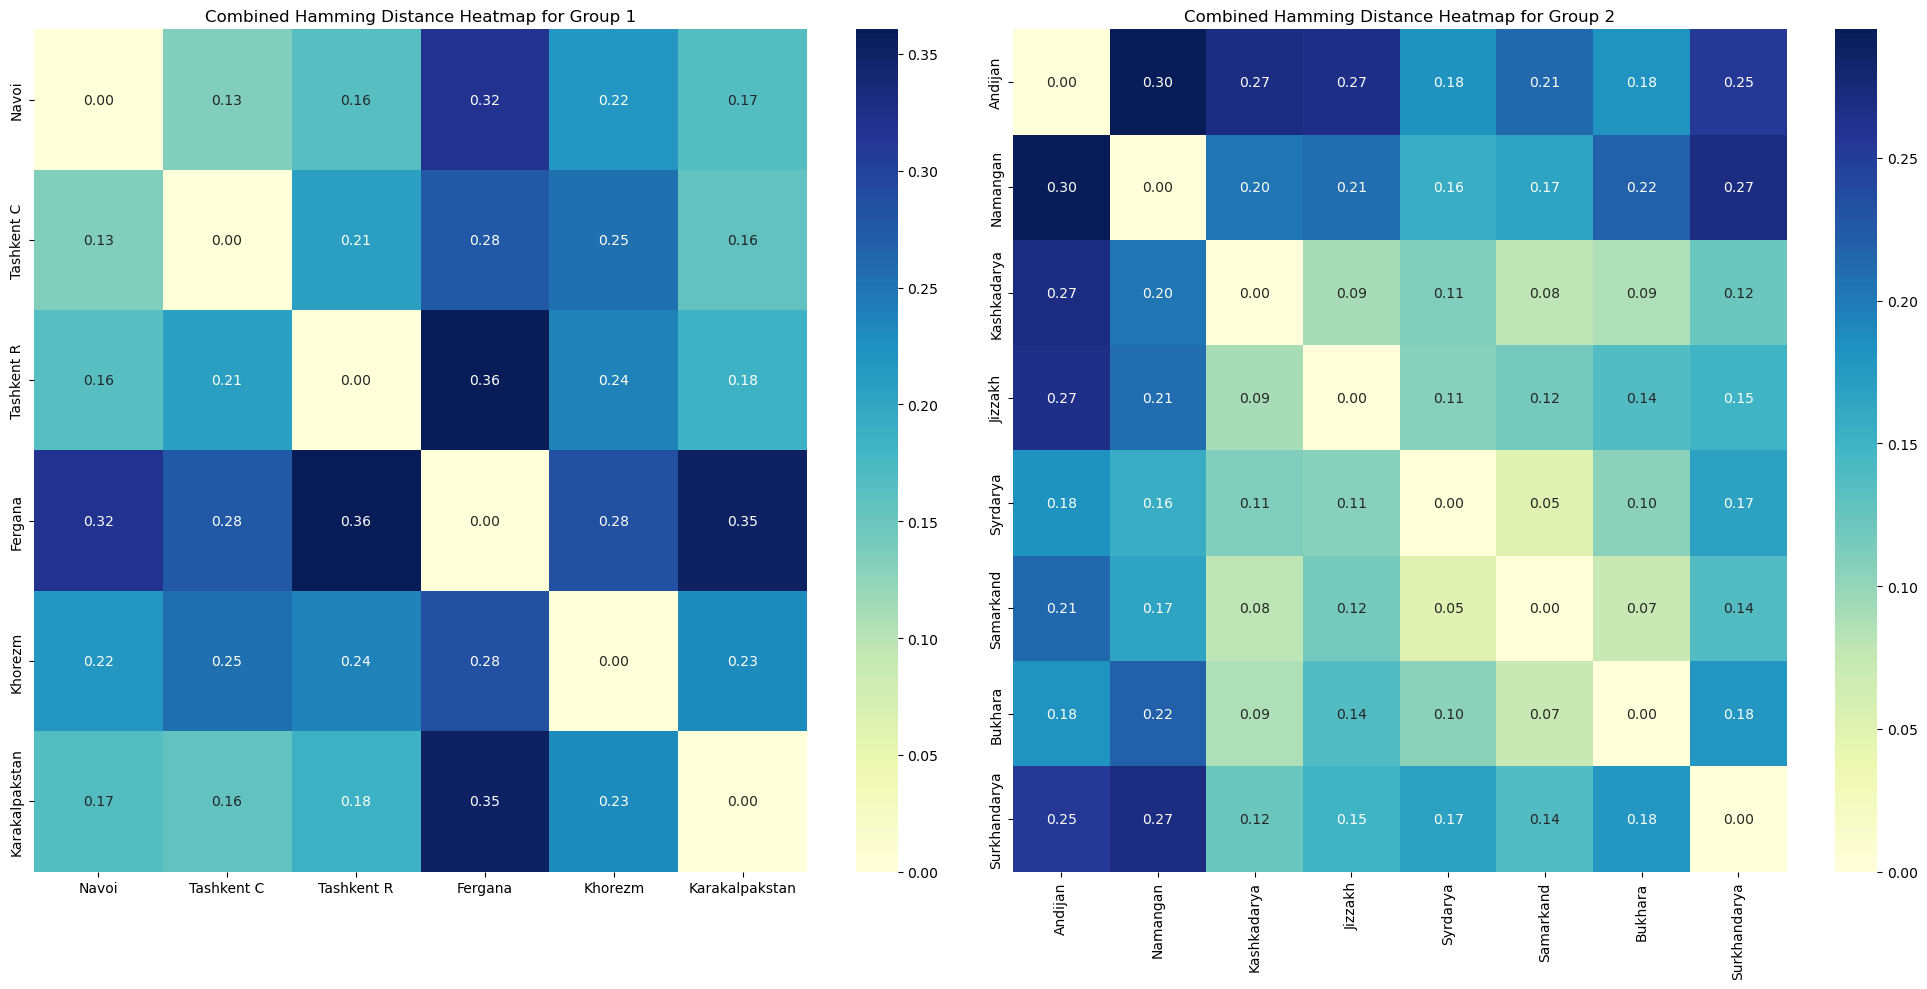

In [16]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Load uploaded files directly into a dictionary
uploaded_files = {
    "Tuberc": pd.read_csv("Tuberc.csv"),
    "Brucellosis": pd.read_csv("Brucellosis.csv"),
    "Dysentery": pd.read_csv("Dysentery.csv"),
    "Measles": pd.read_csv("Measles.csv"),
    "Meningococcal_inf": pd.read_csv("Meningococcal_inf.csv"),
    "Scarlet_fever": pd.read_csv("Scarlet_fever.csv"),
    "Typhoid_fever": pd.read_csv("Typhoid_fever.csv"),
}

# Define the regions for Group 1 and Group 2 based on the case study
group_1_regions = [
    "Navoi", "Tashkent C", "Tashkent R", "Fergana", "Khorezm", "Karakalpakstan"
]

group_2_regions = [
    "Andijan", "Namangan", "Kashkadarya", "Jizzakh", "Syrdarya", "Samarkand", "Bukhara", "Surkhandarya"
]

# Function to calculate combined Hamming Distance for all diseases in a group
def calculate_combined_hamming_distance_fixed(data, group_regions):
    combined_matrix = None
    region_names = []

    # Ensure all regions are aligned across datasets
    for disease, df in data.items():
        # Filter the dataset for the specified group regions
        filtered_data = df[df["Territories"].isin(group_regions)]
        
        # Reindex to ensure consistent region alignment
        filtered_data = filtered_data.set_index("Territories").reindex(group_regions).fillna(0).reset_index()

        # Ensure values are numeric and convert to binary (0 if no cases, 1 if cases)
        binary_df = filtered_data.drop(columns=["Territories", "№", "EZone"], errors="ignore").applymap(lambda x: 1 if pd.to_numeric(x, errors="coerce") > 0 else 0)
        
        # Calculate pairwise Hamming Distance
        hamming_matrix = pdist(binary_df, metric="hamming")
        distance_matrix = squareform(hamming_matrix)

        # Initialize combined matrix with the first disease's matrix
        if combined_matrix is None:
            combined_matrix = distance_matrix
            region_names = filtered_data["Territories"].tolist()
        else:
            # Add the Hamming matrix of each disease to the combined matrix
            combined_matrix += distance_matrix

    # Normalize the combined matrix by the number of diseases
    combined_matrix /= len(data)

    return combined_matrix, region_names

# Recalculate combined Hamming Distance matrices for Group 1 and Group 2
combined_hamming_group_1, regions_group_1 = calculate_combined_hamming_distance_fixed(uploaded_files, group_1_regions)
combined_hamming_group_2, regions_group_2 = calculate_combined_hamming_distance_fixed(uploaded_files, group_2_regions)

# Plotting combined heatmaps for Group 1 and Group 2 side by side with values inside each cell
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Group 1 Heatmap
sns.heatmap(
    combined_hamming_group_1,
    xticklabels=regions_group_1,
    yticklabels=regions_group_1,
    cmap="YlGnBu",
    cbar=True,
    annot=True,  # Display values inside cells
    fmt=".2f",
    ax=axes[0]
)
axes[0].set_title("Combined Hamming Distance Heatmap for Group 1")

# Group 2 Heatmap
sns.heatmap(
    combined_hamming_group_2,
    xticklabels=regions_group_2,
    yticklabels=regions_group_2,
    cmap="YlGnBu",
    cbar=True,
    annot=True,  # Display values inside cells
    fmt=".2f",
    ax=axes[1]
)
axes[1].set_title("Combined Hamming Distance Heatmap for Group 2")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming

# Updated Hamming Distance Calculation Function
def aggregate_hamming(data_files, regions):
    all_hamming_distances = []
    
    for file_name, data in data_files.items():
        print(f"\nProcessing file: {file_name}")
        # Normalize territories and regions
        data["Territories"] = data["Territories"].str.strip().str.lower()
        regions = [r.strip().lower() for r in regions]

        # Filter data by regions
        filtered_data = data[data["Territories"].isin(regions)]
        if filtered_data.empty:
            print(f"No matching regions found in {file_name}. Skipping.")
            continue

        # Melt the data and process as before
        melted_data = filtered_data.melt(
            id_vars=["№", "Territories", "EZone"], var_name="Year", value_name="Value"
        ).dropna(subset=["Year", "Value"])

        melted_data["Year"] = pd.to_numeric(melted_data["Year"], errors="coerce").fillna(0).astype(int)
        melted_data["Value"] = pd.to_numeric(melted_data["Value"], errors="coerce").fillna(0)

        min_year = melted_data["Year"].min()
        max_year = melted_data["Year"].max()

        if max_year > min_year:
            for year in range(min_year, max_year):
                current_values = melted_data[melted_data["Year"] == year]["Value"].values
                next_values = melted_data[melted_data["Year"] == year + 1]["Value"].values

                max_length = max(len(current_values), len(next_values))
                current_values = np.pad(current_values, (0, max_length - len(current_values)), constant_values=0)
                next_values = np.pad(next_values, (0, max_length - len(next_values)), constant_values=0)

                hamming_distance = hamming(current_values, next_values)
                all_hamming_distances.append({"Year": year + 1, "Hamming Distance": hamming_distance})

    if all_hamming_distances:
        return pd.DataFrame(all_hamming_distances)
    else:
        raise ValueError("No valid data to calculate Hamming Distance.")

# Function to prepare the data for plotting
def prepare_hamming_data(data, quartiles):
    if "Hamming Distance" in data.columns:
        pivot_data = data.pivot_table(values="Hamming Distance", index="Year", aggfunc="mean").reset_index()
        for i, q in enumerate(quartiles):
            pivot_data[f"D{i+1}"] = pivot_data["Hamming Distance"]
        return pivot_data
    else:
        raise ValueError("Missing 'Hamming Distance' column in the data.")

# Plot function
def plot_cluster_trajectory_with_quartiles(data, group_name):
    plt.figure(figsize=(12, 8))
    for col in data.columns[1:]:
        plt.plot(data["Year"], data[col], marker="o", label=col)

    plt.axhline(y=0.25, color="lightblue", linestyle="--", label="Q1 Boundary")
    plt.axhline(y=0.50, color="lightgreen", linestyle="--", label="Q2 Boundary")
    plt.axhline(y=0.75, color="lightyellow", linestyle="--", label="Q3 Boundary")
    plt.axhline(y=1.0, color="lightcoral", linestyle="--", label="Q4 Boundary")

    plt.title(f"Cluster Trajectories for {group_name} (All Years)", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Quartile", fontsize=14)
    plt.legend(title="Diseases", fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Reload the uploaded files to ensure fresh data
uploaded_files = {
    "Brucellosis": pd.read_csv("Brucellosis.csv"),
    "Dysentery": pd.read_csv("Dysentery.csv"),
    "Measles": pd.read_csv("Measles.csv"),
    "Meningococcal_inf": pd.read_csv("Meningococcal_inf.csv"),
    "Scarlet_fever": pd.read_csv("Scarlet_fever.csv"),
    "Tuberc": pd.read_csv("Tuberc.csv"),
    "Typhoid_fever": pd.read_csv("Typhoid_fever.csv")
}

# Define regions for Group 1 and Group 2
group_1_regions = ["Industrialized", "Less Developed"]
group_2_regions = ["Agricultural", "Emerging"]

# Calculate Hamming distances
group1_hamming = aggregate_hamming(uploaded_files, group_1_regions)
group2_hamming = aggregate_hamming(uploaded_files, group_2_regions)

# Prepare the datasets
group1_prepared = prepare_hamming_data(group1_hamming, ["Q1", "Q2", "Q3", "Q4"])
group2_prepared = prepare_hamming_data(group2_hamming, ["Q1", "Q2", "Q3", "Q4"])

# Plot for Group 1
plot_cluster_trajectory_with_quartiles(group1_prepared, "Group 1: Industrialized & Less-Developed")

# Plot for Group 2
plot_cluster_trajectory_with_quartiles(group2_prepared, "Group 2: Agricultural & Emerging")


Processing file: Brucellosis
No matching regions found in Brucellosis. Skipping.

Processing file: Dysentery
No matching regions found in Dysentery. Skipping.

Processing file: Measles
No matching regions found in Measles. Skipping.

Processing file: Meningococcal_inf
No matching regions found in Meningococcal_inf. Skipping.

Processing file: Scarlet_fever
No matching regions found in Scarlet_fever. Skipping.

Processing file: Tuberc
No matching regions found in Tuberc. Skipping.

Processing file: Typhoid_fever
No matching regions found in Typhoid_fever. Skipping.


ValueError: No valid data to calculate Hamming Distance.